In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcollection
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# import manual scan data
# housing position and orientation in optitrack frame
# sensed forces and moments in FT sensor frame
manual_data = np.genfromtxt('manual_scan_data_2023-03-09.14_55_26.csv', delimiter=',', skip_header=1)
manual_time = manual_data[:,0]/1e6 # convert from microseconds to seconds
manual_optitrack_time = manual_data[:,1]
manual_housing_position = manual_data[:,2:5]
manual_housing_orientation = np.swapaxes(np.reshape(manual_data[:,5:14], (-1,3,3)), 1, 2)
manual_sensed_forces = manual_data[:,14:17] # not in local sensor frame, need to rotate from adapter to sensor
manual_sensed_moments = manual_data[:,17:20] # not in local sensor frame, need to rotate from adapter to sensor
manual_sensed_forces_raw = manual_data[:,20:23]
manual_sensed_moments_raw = manual_data[:,23:26]
manual_num_data_points = np.size(manual_time)

FileNotFoundError: manual_scan_data_2023-03-09.14_55_26.csv not found.

In [3]:
# correction for raw sensed forces + moments to local sensor frame
manual_sensed_forces_local_frame = manual_sensed_forces_raw.copy()
manual_sensed_moments_local_frame = manual_sensed_moments_raw.copy()
force_bias = np.array([-3.85127, 1.28588, -0.0535624, -0.0185233, 0.271245, 0.00968462])
tool_mass = 0.591466
tool_com = np.array([0.000991119, -0.0017257, 0.0894378])
# NOTE: +Y sensor axis aligned with axis pointing out of butterfly probe's battery indicator
# should be aligned with -Y sensor axis in future
# update: should be aligned with +X sensor axis in future
R_sensor_housing = np.array([
    [1,  0, 0],
    [0,  0, 1],
    [0, -1, 0]
])

g_optitrack = np.array([0, -9.81, 0]) # optitrack +Y is up

# correction for probe tip position in housing frame
manual_probe_position = manual_housing_position.copy()
# probe_pos_in_housing_frame = np.array([0, -0.23, 0])
probe_pos_in_housing_frame = np.array([0, -0.2475, 0])

manual_sensed_forces_local_frame -= force_bias[0:3]
manual_sensed_moments_local_frame -= force_bias[3:6]
init_force = np.zeros(3)
for i in range(manual_num_data_points):
    # correct sensed forces and moments in local frame
    p_tool_local_frame = tool_mass * (R_sensor_housing @ np.transpose(manual_housing_orientation[i])) @ g_optitrack
    manual_sensed_forces_local_frame[i] += p_tool_local_frame
    manual_sensed_moments_local_frame[i] += np.cross(tool_com, p_tool_local_frame)
    if i == 0: init_force = manual_sensed_forces_local_frame[i]
    manual_sensed_forces_local_frame[i] -= init_force
    
    # correct probe tip position in optitrack frame
    manual_probe_position[i] = manual_housing_position[i] + (manual_housing_orientation[i] @ probe_pos_in_housing_frame)

# describe probe orientation (like robot EE frame) instead of housing orientation in optitrack frame
R_housing_probe = np.array([
    [0, -1,  0],
    [0,  0, -1],
    [1,  0,  0]
])
manual_probe_orientation = manual_housing_orientation @ R_housing_probe
    
# affine transformation from optitrack frame to phantom frame
R_phantom_optitrack = np.array([
    [ 0, 0, -1],
    [-1, 0,  0],
    [ 0, 1,  0]
])
# x: 60+400-200mm
# y: -300+50mm
# z: 0
optitrack_origin_in_phantom_frame = np.array([0.06+0.4-0.2, -0.3+0.05, 0.0])

manual_probe_position_phantom_frame = (R_phantom_optitrack @ (manual_probe_position).T).T + optitrack_origin_in_phantom_frame
manual_probe_orientation_phantom_frame = R_phantom_optitrack @ manual_probe_orientation

manual_probe_orientation_phantom_frame_axial = manual_probe_orientation_phantom_frame[:,:,2].copy()

# print(manual_probe_position[0])
# print(manual_probe_position_phantom_frame[0])
# print(manual_probe_orientation[0])
# print(manual_probe_orientation_phantom_frame[0])
    
# flip x- and y-axes on sensed force and moment data
# manual_sensed_forces_local_frame[:,0] *= -1
# manual_sensed_forces_local_frame[:,1] *= -1
# manual_sensed_moments_local_frame[:,0] *= -1
# manual_sensed_moments_local_frame[:,1] *= -1    

NameError: name 'manual_sensed_forces_raw' is not defined

In [4]:
# import haptic scan robot data
# robot values in robot base frame except posori in EE frame
haptic_robot_data = np.genfromtxt('haptic_device_pass_3_full_abdomen_robot_data_2023-04-21.13_51_33.csv',
                                  delimiter=',', skip_header=1, skip_footer=0)
haptic_robot_time = haptic_robot_data[:,0]/1e6 # convert from microseconds to seconds
haptic_robot_controller_time = haptic_robot_data[:,1]
haptic_robot_ee_position = haptic_robot_data[:,2:5]
haptic_robot_ee_linear_velocity = haptic_robot_data[:,5:8]
haptic_robot_ee_angular_velocity = haptic_robot_data[:,8:11]
haptic_robot_proxy_position = haptic_robot_data[:,11:14]
haptic_robot_joint_angles = haptic_robot_data[:,14:21]
haptic_robot_joint_velocities = haptic_robot_data[:,21:28]
haptic_robot_joint_command_torques = haptic_robot_data[:,28:35]
haptic_robot_sensed_forces = haptic_robot_data[:,35:38]
haptic_robot_sensed_moments = haptic_robot_data[:,38:41]
haptic_robot_desired_force = haptic_robot_data[:,41:44]
haptic_robot_posori_sensed_forces = haptic_robot_data[:,44:47]
haptic_robot_posori_sensed_moments = haptic_robot_data[:,47:50]
haptic_robot_ee_orientation = np.swapaxes(np.reshape(haptic_robot_data[:,50:59], (-1,3,3)), 1, 2)
haptic_robot_force_space_dimension = haptic_robot_data[:,59]
haptic_robot_sigma_force = np.swapaxes(np.reshape(haptic_robot_data[:,60:69], (-1,3,3)), 1, 2)
haptic_robot_num_data_points = np.size(haptic_robot_time)

# use following naming convention for plotting convenience
haptic_probe_position = haptic_robot_ee_position.copy()
haptic_probe_orientation = haptic_robot_ee_orientation.copy()

# affine transformation from robot frame to phantom frame
R_phantom_robot = np.array([
    [ 0, 1, 0],
    [-1, 0, 0],
    [ 0, 0, 1]
])
# x: 0
# y: 10.625"*(5/2)+61mm
# z: 0.5"
METER_PER_INCH = 0.0254
robot_origin_in_phantom_frame = np.array([0.0, 10.625*(5/2)*METER_PER_INCH+0.061, 0.5*METER_PER_INCH])

haptic_probe_position_phantom_frame = (R_phantom_robot @ (haptic_probe_position).T).T + robot_origin_in_phantom_frame
haptic_probe_orientation_phantom_frame = R_phantom_robot @ haptic_probe_orientation

haptic_probe_orientation_phantom_frame_axial = haptic_probe_orientation_phantom_frame[:,:,2].copy()

# print(haptic_probe_position[0])
# print(haptic_probe_position_phantom_frame[0])
# print(haptic_probe_orientation[0])
# print(haptic_probe_orientation_phantom_frame[0])

FileNotFoundError: haptic_device_pass_3_full_abdomen_robot_data_2023-04-21.13_51_33.csv not found.

In [5]:
# rotate robot sensed forces from world frame to local EE frame
haptic_robot_sensed_forces_local_frame = np.zeros_like(haptic_robot_sensed_forces)
haptic_robot_sensed_moments_local_frame = np.zeros_like(haptic_robot_sensed_moments)
for i in range(haptic_robot_num_data_points):
    haptic_robot_sensed_forces_local_frame[i] = np.transpose(haptic_robot_ee_orientation[i]) @ haptic_robot_sensed_forces[i]
    haptic_robot_sensed_moments_local_frame[i] = np.transpose(haptic_robot_ee_orientation[i]) @ haptic_robot_sensed_moments[i]

NameError: name 'haptic_robot_sensed_forces' is not defined

In [6]:
# import haptic scan device data
haptic_device_data = np.genfromtxt('haptic_device_pass_3_full_abdomen_haptic_data_2023-04-21.13_51_33.csv', delimiter=',', skip_header=1)
haptic_device_time = haptic_device_data[:,0]/1e6 # convert from microseconds to seconds
haptic_device_controller_time = haptic_device_data[:,1]
haptic_device_position = haptic_device_data[:,2:5]
haptic_device_linear_velocity = haptic_device_data[:,5:8]
haptic_device_angular_velocity = haptic_device_data[:,8:11]
haptic_device_proxy_position = haptic_device_data[:,11:14]
haptic_device_command_force = haptic_device_data[:,14:17]
haptic_device_desired_force = haptic_device_data[:,17:20]
haptic_device_linear_centering_force = haptic_device_data[:,20:23]
haptic_device_linear_damping_force = haptic_device_data[:,23:26]
haptic_device_rotational_damping_moment = haptic_device_data[:,26:29]
haptic_device_orientation = np.swapaxes(np.reshape(haptic_device_data[:,29:38], (-1,3,3)), 1, 2)
haptic_device_num_data_points = np.size(haptic_device_time)

FileNotFoundError: haptic_device_pass_3_full_abdomen_haptic_data_2023-04-21.13_51_33.csv not found.

In [7]:
# import manual scan auto playback robot data
# robot values in robot base frame except posori in EE frame
auto_data = np.genfromtxt('manual_scan_playback_pass_1_data_2023-05-17.22_13_22.csv',
                          delimiter=',', skip_header=1, skip_footer=0)
auto_time = auto_data[:,0]/1e6 # convert from microseconds to seconds
auto_controller_time = auto_data[:,1]
auto_ee_position = auto_data[:,2:5]
auto_ee_linear_velocity = auto_data[:,5:8]
auto_ee_angular_velocity = auto_data[:,8:11]
auto_proxy_position = auto_data[:,11:14]
auto_joint_angles = auto_data[:,14:21]
auto_joint_velocities = auto_data[:,21:28]
auto_joint_command_torques = auto_data[:,28:35]
auto_sensed_forces = auto_data[:,35:38]
auto_sensed_moments = auto_data[:,38:41]
auto_desired_force = auto_data[:,41:44]
auto_posori_sensed_forces = auto_data[:,44:47]
auto_posori_sensed_moments = auto_data[:,47:50]
auto_ee_orientation = np.swapaxes(np.reshape(auto_data[:,50:59], (-1,3,3)), 1, 2)
auto_proxy_orientation = np.swapaxes(np.reshape(auto_data[:,59:68], (-1,3,3)), 1, 2)
auto_force_space_dimension = auto_data[:,68]
auto_sigma_force = np.swapaxes(np.reshape(auto_data[:,69:78], (-1,3,3)), 1, 2)
auto_num_data_points = np.size(auto_time)

# use following naming convention for plotting convenience
auto_probe_position = auto_ee_position.copy()
auto_probe_orientation = auto_ee_orientation.copy()
auto_proxy_position = auto_proxy_position.copy()
auto_proxy_orientation = auto_proxy_orientation.copy()

# affine transformation from robot frame to phantom frame
R_phantom_robot = np.array([
    [-1,  0, 0],
    [ 0, -1, 0],
    [ 0,  0, 1]
])

# x: 3.75"+10.625"*(2)+61mm-200mm-0.1?
# y: 5.5"+10.625"*(3/2)-300mm
# z: 0.5"
METER_PER_INCH = 0.0254
robot_origin_in_phantom_frame_old = np.array([(3.75+2*10.625)*METER_PER_INCH+0.061-0.2-0.1, (5.5+(10.625*(3/2)))*METER_PER_INCH-0.3, 0.5*METER_PER_INCH])

# affine transformation from optitrack frame to phantom frame
R_phantom_optitrack = np.array([
    [ 0, 0, -1],
    [-1, 0,  0],
    [ 0, 1,  0]
])
optitrack_origin_in_phantom_frame = np.array([0.06+0.4-0.2, -0.3+0.05, 0.0])
phantom_origin_in_optitrack_frame = R_phantom_optitrack.T @ (-optitrack_origin_in_phantom_frame)
robot_origin_in_optitrack_frame = np.array([
    0.050 - ((5.5 + (1.5*10.625))*METER_PER_INCH),
    0.5*METER_PER_INCH,
    0.560 - ((3.75 + (2*10.625))*METER_PER_INCH + 0.061)
])
robot_origin_in_phantom_frame = R_phantom_optitrack @ (robot_origin_in_optitrack_frame - phantom_origin_in_optitrack_frame)

# print(optitrack_origin_in_phantom_frame)
# print(phantom_origin_in_optitrack_frame)
# print(robot_origin_in_phantom_frame)
# print(robot_origin_in_phantom_frame_old)

auto_probe_position_phantom_frame = (R_phantom_robot @ (auto_probe_position).T).T + robot_origin_in_phantom_frame
auto_probe_orientation_phantom_frame = R_phantom_robot @ auto_probe_orientation

auto_probe_orientation_phantom_frame_axial = auto_probe_orientation_phantom_frame[:,:,2].copy()

auto_proxy_position_phantom_frame = (R_phantom_robot @ (auto_proxy_position).T).T + robot_origin_in_phantom_frame
auto_proxy_orientation_phantom_frame = R_phantom_robot @ auto_proxy_orientation

FileNotFoundError: manual_scan_playback_pass_1_data_2023-05-17.22_13_22.csv not found.

In [8]:
# rotate robot sensed forces from world frame to local EE frame
auto_sensed_forces_local_frame = np.zeros_like(auto_sensed_forces)
auto_sensed_moments_local_frame = np.zeros_like(auto_sensed_moments)
for i in range(auto_num_data_points):
    auto_sensed_forces_local_frame[i] = np.transpose(auto_ee_orientation[i]) @ auto_sensed_forces[i]
    auto_sensed_moments_local_frame[i] = np.transpose(auto_ee_orientation[i]) @ auto_sensed_moments[i]

In [9]:
planes = ["transverse", "sagittal"]
organs = ["gallbladder", "pancreas", "right_kidney", "liver"]
scan_types = ["manual", "haptic"]

plane = planes[0]
organ = organs[1]

**Plot over organs in manual scan data**\
*Transverse plane*\
0:06 - 1:09 liver\
1:15 - 2:03 pancreas\
1:43 - 1:58 gallbladder\
2:04 - 2:53 right kidney (maybe switch to left)

*Sagittal plane*\
4:20 - 4:30 gallbladder\
4:44 - 4:59 right kidney\
5:06 - 5:23 left kidney

*Transverse plane*\
6.52s   69s liver\
75.4s	124.62s pancreas\
106.84s	116.38s gallbladder\
124.62s	175.14s right kidney

*Sagittal plane*\
177.34s	202.42s liver\
263.38s	271.78s gallbladder\
286.18s	299s right kidney

In [10]:
if plane == "transverse":
    # transverse liver
    if organ == "liver":
        time_start = (0 * 60) + 6
        time_end = (1 * 60) + 9

    # transverse pancreas
    # time_start = (1 * 60) + 15
    # time_end = (2 * 60) + 3
    elif organ == "pancreas":
        time_start = 75.4
        time_end = 124.62

    # time_start = manual_time.min()
    # time_end = manual_time.max()

    # transverse gallbladder
    elif organ == "gallbladder":
        time_start = (1 * 60) + 43
        time_start += 2.5
        time_end = (1 * 60) + 58
        time_end -= 0

    # transverse right kidney
    elif organ == "right_kidney":
        time_start = (2 * 60) + 4
        time_end = (2 * 60) + 53
        
elif plane == "sagittal":
    # sagittal gallbladder
    if organ == "gallbladder":
        time_start = (4 * 60) + 20
        time_end = (4 * 60) + 30

    # sagittal right kidney
    if organ == "right_kidney":
        time_start = (4 * 60) + 44
        time_end = (4 * 60) + 59
        # time_start = 286
        # time_end = 300

    # sagittal left kidney
    # time_start = (5 * 60) + 6
    # time_end = (5 * 60) + 23

data_ind = np.where(np.logical_and(manual_time>=time_start, 
                                   manual_time<=time_end))

manual_selection_time = manual_time[data_ind].copy()
manual_selection_probe_position = manual_probe_position_phantom_frame[data_ind].copy()
manual_selection_probe_orientation = manual_probe_orientation_phantom_frame[data_ind].copy()
manual_selection_probe_orientation_axial = manual_probe_orientation_phantom_frame_axial[data_ind].copy()
manual_selection_sensed_forces_local_frame = manual_sensed_forces_local_frame[data_ind].copy()

# timepoints for auto scan should match manual scan
if plane == "sagittal" and organ == "gallbladder":
    time_start -= 1.5
    time_end += 1.5
data_ind = np.where(np.logical_and(auto_time>=time_start, 
                                   auto_time<=time_end))

auto_selection_time = auto_time[data_ind].copy()
auto_selection_probe_position = auto_probe_position_phantom_frame[data_ind].copy()
auto_selection_probe_orientation = auto_probe_orientation_phantom_frame[data_ind].copy()
auto_selection_probe_orientation_axial = auto_probe_orientation_phantom_frame_axial[data_ind].copy()
auto_selection_sensed_forces_local_frame = auto_sensed_forces_local_frame[data_ind].copy()
auto_selection_proxy_position = auto_proxy_position_phantom_frame[data_ind].copy() # for reference to manual scan
auto_selection_proxy_orientation = auto_proxy_position_phantom_frame[data_ind].copy()

**Plot over organs in haptic scan data**\
*Transverse plane*\
0:26 - 1:44/3:03 liver\
3:04 - 3:54 gallbladder\
4:11 - 4:28 right kidney\
4:44 - 5:26 pancreas\
6:32 - 6:58 left kidney

*Sagittal plane*\
8:44 - 9:10 gallbladder\
9:43 - 9:57 right kidney\
10:32 - 10:42 left kidney

In [11]:
if plane == "transverse":
    # transverse liver
    if organ == "liver":
        time_start = (0 * 60) + 26
        time_end = (1 * 60) + 44
        
        time_start += 20
        time_end += -20

    # transverse right kidney
    elif organ == "right_kidney":
        time_start = (4 * 60) + 11
        time_end = (4 * 60) + 28

    # transverse pancreas
    elif organ == "pancreas":
        time_start = (4 * 60) + 44
        time_end = (5 * 60) + 26

        # time_start = (6 * 60) + 12
        # time_end = (6 * 60) + 30

    # transverse gallbladder
    elif organ == "gallbladder":
        time_start = (3 * 60) + 4
        time_end = (3 * 60) + 54
        
        time_start += 0
        time_end += -20

elif plane == "sagittal":
    # sagital gallbladder
    if organ == "gallbladder":
        time_start = (8 * 60) + 44
        time_end = (9 * 60) + 10

    # sagittal right kidney
    elif organ == "right_kidney":
        time_start = (9 * 60) + 43
        time_end = (9 * 60) + 57

    # sagittal left kidney
    # time_start = (10 * 60) + 32
    # time_end = (10 * 60) + 42

# time_start += -5
# time_end -= 5

data_ind = np.where(np.logical_and(haptic_robot_time>=time_start, 
                                   haptic_robot_time<=time_end))

haptic_selection_time = haptic_robot_time[data_ind].copy()
haptic_selection_probe_position = haptic_probe_position_phantom_frame[data_ind].copy()
haptic_selection_probe_orientation = haptic_probe_orientation_phantom_frame[data_ind].copy()
haptic_selection_probe_orientation_axial = haptic_probe_orientation_phantom_frame_axial[data_ind].copy()
haptic_selection_sensed_forces_local_frame = haptic_robot_sensed_forces_local_frame[data_ind].copy()

haptic_selection_device_desired_force = haptic_device_desired_force[data_ind].copy()

Search for similar position + orientation between manual and haptic scans for image comparison

In [12]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [13]:
pos_diff = manual_selection_probe_position[:] - haptic_selection_probe_position[:, np.newaxis, :]
pos_diff_norm = np.linalg.norm(pos_diff, axis=2) # rows for haptic selection, cols for manual selection
pos_ij_min = np.unravel_index(pos_diff_norm.argmin(), pos_diff_norm.shape)
haptic_pos_ind, manual_pos_ind = pos_ij_min

# delta_phi = np.cross(manual_selection_probe_orientation[manual_pos_ind,:,0], haptic_selection_probe_orientation[haptic_pos_ind,:,0])
# delta_phi += np.cross(manual_selection_probe_orientation[manual_pos_ind,:,1], haptic_selection_probe_orientation[haptic_pos_ind,:,1])
# delta_phi += np.cross(manual_selection_probe_orientation[manual_pos_ind,:,2], haptic_selection_probe_orientation[haptic_pos_ind,:,2])
# delta_phi *= -0.5

# print(manual_selection_probe_orientation[manual_pos_ind])
# print(haptic_selection_probe_orientation[haptic_pos_ind])

# print(delta_phi)
# print(np.linalg.norm(delta_phi))

# print(manual_selection_probe_orientation_axial[manual_pos_ind])
# print(haptic_selection_probe_orientation_axial[haptic_pos_ind])

theta = angle_between(manual_selection_probe_orientation_axial[manual_pos_ind], haptic_selection_probe_orientation_axial[haptic_pos_ind])
print("Angle between manual and haptic normals:", np.rad2deg(theta), "degrees")

# print(manual_selection_sensed_forces_local_frame[manual_pos_ind])
# print(haptic_selection_sensed_forces_local_frame[haptic_pos_ind])

print("Manual position:", manual_selection_probe_position[manual_pos_ind], "meters")
print("Haptic position:", haptic_selection_probe_position[haptic_pos_ind], "meters")
print("position difference norm:", pos_diff_norm[pos_ij_min], "meters")

print("Manual time:", manual_selection_time[manual_pos_ind], "seconds")
print("Haptic time:", haptic_selection_time[haptic_pos_ind], "seconds")

Angle between manual and haptic normals: 6.054311206510684 degrees
Manual position: [0.00280091 0.14549124 0.17619807] meters
Haptic position: [0.00418022 0.1457905  0.198429  ] meters
position difference norm: 0.022275691065447436 meters
Manual time: 81.12 seconds
Haptic time: 323.877 seconds


In [14]:
# find smallest angle between closest points
pos_tol = 2.5e-2
if organ == "gallbladder" and plane == "transverse": pos_tol = 2.5e-2
close_ind = np.where(pos_diff_norm < pos_tol)

thetas = np.zeros(close_ind[0].size)
for i in range(thetas.size):
    thetas[i] = angle_between(manual_selection_probe_orientation_axial[close_ind[1][i]], haptic_selection_probe_orientation_axial[close_ind[0][i]])
    
min_theta_ind = close_ind[0][thetas.argmin()], close_ind[1][thetas.argmin()]
haptic_ori_ind, manual_ori_ind = min_theta_ind

print("Angle between manual and haptic normals:", np.rad2deg(thetas.min()), "degrees")

print("Manual position:", manual_selection_probe_position[manual_ori_ind], "meters")
print("Haptic position:", haptic_selection_probe_position[haptic_ori_ind], "meters")
print("position difference norm:", pos_diff_norm[min_theta_ind], "meters")

print("Manual time:", manual_selection_time[manual_ori_ind], "seconds")
print("Haptic time:", haptic_selection_time[haptic_ori_ind], "seconds")

Angle between manual and haptic normals: 0.6751221772154044 degrees
Manual position: [0.00031526 0.14215112 0.1753122 ] meters
Haptic position: [0.00228608 0.1491675  0.199186  ] meters
position difference norm: 0.024961410059580184 meters
Manual time: 80.7958 seconds
Haptic time: 323.451 seconds


Find similar position + orientation between entire auto and single manual scan point for image comparison

In [15]:
pos_diff = auto_selection_probe_position[:,:3] - manual_selection_probe_position[manual_ori_ind,:3]
pos_diff_norm = np.linalg.norm(pos_diff, axis=1)
auto_pos_ind = pos_diff_norm.argmin()

# print(pos_diff_norm, auto_pos_ind)
print(auto_selection_probe_position[auto_pos_ind])
print(manual_selection_probe_position[manual_ori_ind])

theta = angle_between(manual_selection_probe_orientation_axial[manual_ori_ind], auto_selection_probe_orientation_axial[auto_pos_ind])
print("Angle between manual and haptic normals:", np.rad2deg(theta), "degrees")

# use proxy position as similarity reference to manual scan
# pos_diff = auto_selection_proxy_position[:] - manual_selection_probe_position[manual_ori_ind]
# pos_diff_norm = np.linalg.norm(pos_diff, axis=1)
# pos_ind_min = pos_diff_norm.argmin()

# print(pos_diff_norm, pos_ind_min)
# print(auto_selection_probe_position[pos_ind_min])
# print(auto_selection_proxy_position[pos_ind_min])
# print(manual_selection_probe_position[manual_ori_ind])

[0.008624  0.1563271 0.187731 ]
[0.00031526 0.14215112 0.1753122 ]
Angle between manual and haptic normals: 11.409726057644209 degrees


In [16]:
# find smallest angle between closest points
pos_tol = 2.5e-2
# if organ == "gallbladder" and plane == "transverse": pos_tol = 1.5e-2
close_ind = np.where(pos_diff_norm < pos_tol)

thetas = np.zeros(close_ind[0].size)
for i in range(thetas.size):
    thetas[i] = angle_between(manual_selection_probe_orientation_axial[manual_ori_ind], auto_selection_probe_orientation_axial[close_ind[0][i]])
    
auto_ori_ind = close_ind[0][thetas.argmin()]

print("Angle between manual and auto normals:", np.rad2deg(thetas.min()), "degrees")

print("Manual position:", manual_selection_probe_position[manual_ori_ind], "meters")
print("Auto position:", auto_selection_probe_position[auto_ori_ind], "meters")
print("position difference norm:", pos_diff_norm[auto_ori_ind], "meters")

print("Manual time:", manual_selection_time[manual_ori_ind], "seconds")
print("Auto time:", auto_selection_time[auto_ori_ind], "seconds")

Angle between manual and auto normals: 7.371997181037031 degrees
Manual position: [0.00031526 0.14215112 0.1753122 ] meters
Auto position: [-0.010327   0.1611223  0.187601 ] meters
position difference norm: 0.024983553177762987 meters
Manual time: 80.7958 seconds
Auto time: 99.0334 seconds


In [17]:
plt.plot(manual_time, manual_housing_position[:,0], 'r')
plt.plot(manual_time, manual_housing_position[:,1], 'g')
plt.plot(manual_time, manual_housing_position[:,2], 'b')
plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.title('Housing position in optitrack frame')
plt.legend(['x', 'y', 'z'], loc='center right')
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [18]:
fig, axs = plt.subplots(3, 1, sharex='col')
axs[0].plot(manual_time, manual_probe_position[:,0], 'r')
axs[1].plot(manual_time, manual_probe_position[:,1], 'g')
axs[2].plot(manual_time, manual_probe_position[:,2], 'b')
axs[0].plot(manual_time, manual_housing_position[:,0], '--r')
axs[1].plot(manual_time, manual_housing_position[:,1], '--g')
axs[2].plot(manual_time, manual_housing_position[:,2], '--b')
# plt.yticks(np.linspace(-0.5, 0.5, 5))
axs[0].set_title('Probe position in optitrack frame')
# plt.legend(['x', 'y', 'z'], loc='center right')
axs[0].set_ylabel('Position (m)')
axs[1].set_ylabel('Position (m)')
axs[2].set_ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [19]:
fig, axs = plt.subplots(3, 1, sharex='col')
axs[0].plot(manual_time, manual_probe_position_phantom_frame[:,0], 'r')
axs[1].plot(manual_time, manual_probe_position_phantom_frame[:,1], 'g')
axs[2].plot(manual_time, manual_probe_position_phantom_frame[:,2], 'b')
axs[0].plot(manual_time, manual_probe_position[:,0], '--k')
axs[1].plot(manual_time, manual_probe_position[:,1], '--k')
axs[2].plot(manual_time, manual_probe_position[:,2], '--k')
# plt.yticks(np.linspace(-0.5, 0.5, 5))
axs[0].set_title('Probe position in phantom frame')
# plt.legend(['x', 'y', 'z'], loc='center right')
axs[0].set_ylabel('Position (m)')
axs[1].set_ylabel('Position (m)')
axs[2].set_ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [20]:
plt.plot(manual_time, manual_sensed_forces_local_frame[:,0], 'r')
plt.plot(manual_time, manual_sensed_forces_local_frame[:,1], 'g')
plt.plot(manual_time, manual_sensed_forces_local_frame[:,2], 'b')
plt.yticks(np.linspace(-20, 20, 9))
plt.title('Probe sensed force in FT sensor frame')
plt.legend(['x', 'y', 'z'], loc='lower right')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [21]:
plt.plot(manual_time, manual_sensed_moments_local_frame[:,0], 'r')
plt.plot(manual_time, manual_sensed_moments_local_frame[:,1], 'g')
plt.plot(manual_time, manual_sensed_moments_local_frame[:,2], 'b')
plt.yticks(np.linspace(-2, 2, 5))
plt.title('Probe sensed moment in FT sensor frame')
plt.legend(['x', 'y', 'z'], loc='lower right')
plt.ylabel('Moment (N*m)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [22]:
def seg_plot(ax, X, Y, Z, cmap=None, alpha=None, **kargs):
    if cmap is None:
        cmap = plt.get_cmap()
    P = np.array([X, Y]).T.reshape(-1, 1, 2)
    S = np.concatenate([P[:-1], P[1:]], axis=1)
    norm = mcolors.Normalize(vmin=Z.min(), vmax=Z.max())
    C = cmap(norm(Z))
    L = mcollection.LineCollection(S, color=C, alpha=alpha, **kargs)
    plot = ax.add_collection(L)
    ax.set_xlim(X.min()*(1-0.1*np.sign(X.min())), X.max()*(1+0.1*np.sign(X.max())))
    ax.set_ylim(Y.min()*(1-0.1*np.sign(Y.min())), Y.max()*(1+0.1*np.sign(Y.max())))
    return plot

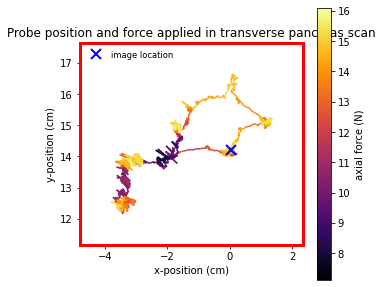

In [23]:
x, y = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy()
z = manual_selection_sensed_forces_local_frame[:,2].copy()

# scale position date
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

fig, ax = plt.subplots(figsize=(5,5))
fig.gca().set_aspect('equal')

path = seg_plot(ax, x, y, z, cmap=cmap)
# path.set_label('_nolegend_')
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical', label="axial force (N)")

# highlight image comparison point
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
# plt.scatter(x,y,s=0, cmap='jet', facecolors='none')
# circle = plt.Circle((x_comp, y_comp), 0.3, color='b', linewidth=2, fill=False, alpha=1)
# comp = ax.add_artist(circle)

# plt.plot(x_comp, y_comp, marker='o', markersize=20, markeredgecolor='b', markerfacecolor='None')
plt.plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

# symbol = u'\u22A1'
# plt.text(x_comp[0], y_comp[0], symbol, fontname='STIXGeneral', label="Comp",
#          size=30, va='center', ha='center', clip_on=True)

# marker = "$%s$" % symbol
# plt.plot(x_comp, y_comp, 'b', marker=marker, markersize=20,
#          linestyle="None", label="comp")

directions = ['bottom', 'top', 'right', 'left']
for i, direction in enumerate(directions):
    ax.spines[direction].set_color('red')
    ax.spines[direction].set_linewidth('3')

# fig.patch.set_edgecolor('red')
# fig.patch.set_linewidth('5')  

plt.title('Probe position and force applied in transverse pancreas scan')
plt.ylabel('y-position (cm)')
plt.xlabel('x-position (cm)')

offset = 1
ax.set_xlim([x.min()-offset, x.max()+offset])
ax.set_ylim([y.min()-offset, y.max()+offset])

ax.legend(loc='upper left', fontsize='small', frameon=False)

plt.show()

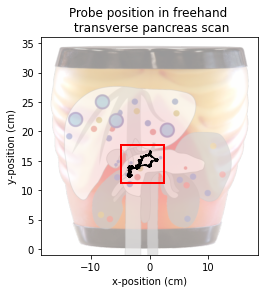

In [49]:
x, y = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy()
z = manual_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

dpi = 600
# fig, ax = plt.subplots(figsize=(3600/dpi,2400/dpi))
fig, ax = plt.subplots()
fig.gca().set_aspect('equal')

# seg_plot(ax, x, y, z, cmap=cmap)
ax.plot(x, y, 'k')
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# cbar = fig.colorbar(sm, ax=None, orientation='vertical')

# plot bounding box around probe path
rect_offset = 1
rect = patches.Rectangle((x.min()-rect_offset, y.min()-rect_offset),
                         x.ptp()+2*rect_offset, y.ptp()+2*rect_offset,
                         linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.title(f'Probe position in freehand \n {plane} {organ} scan')
plt.ylabel('y-position (cm)')
plt.xlabel('x-position (cm)')

# plot phantom
# black phantom top (560-145)=415 px wide (31cm)
# empty left space next to top 145px wide
# phantom black top to black bottom (498-38)=460 px tall
phantom_width_top = 415
CM_PER_PX = 31/phantom_width_top
empty_width_left = 145
empty_width_right = empty_width_left
phantom_height = 460
empty_height_top = 38
empty_height_bottom = 532-498

img = plt.imread("images/phantom_anatomy.png")
plt.imshow(img, alpha=0.4, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])

plt.xlim([-17.5-1, 17.5+1])
plt.ylim([0-1, 35+1])

plt.savefig(f"plots/probe_path_phantom_{plane}_{organ}_manual.png", dpi=dpi, bbox_inches='tight')
plt.show()

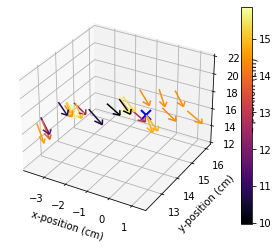

In [25]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = manual_selection_probe_position[::skip,0].copy(), manual_selection_probe_position[::skip,1].copy(), manual_selection_probe_position[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# make the direction data for the arrows
u, v, w = manual_selection_probe_orientation_axial[::skip,0].copy(), manual_selection_probe_orientation_axial[::skip,1].copy(), manual_selection_probe_orientation_axial[::skip,2].copy()

# plt.plot(manual_selection_housing_position[:,0], manual_selection_housing_position[:,1], manual_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = manual_selection_sensed_forces_local_frame[::skip,2]/manual_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = manual_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

position_scale = 100
# force_scale = 0.1
force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='k', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
colors = norm(axial_force)
colors = np.concatenate((colors, np.repeat(colors, 2)))

# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u, v, w,
#           color=cmap(norm(axial_force)), arrow_length_ratio=0.3, length=2, normalize=True)
plt.colorbar(sm)

# highlight image comparison point
x, y, z = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy(), manual_selection_probe_position[:,2].copy()
x *= 100
y *= 100
z *= 100
u, v, w = manual_selection_probe_orientation_axial[:,0].copy(), manual_selection_probe_orientation_axial[:,1].copy(), manual_selection_probe_orientation_axial[:,2].copy()
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
z_comp = [z[manual_ori_ind]]
u_comp = [u[manual_ori_ind]]
v_comp = [v[manual_ori_ind]]
w_comp = [w[manual_ori_ind]]
comp_force = [manual_selection_sensed_forces_local_frame[manual_ori_ind,2].copy()]
c = axial_force
c = (comp_force - c.min()) / c.ptp()
c = np.concatenate((c, np.repeat(c, 2)))
c = cmap(c)
ax.quiver(x_comp, y_comp, z_comp,
          u_comp, v_comp, w_comp,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
ax.plot(x_comp, y_comp, z_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

# position_scale = 100
# force_scale = 0.1
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           -u*alphas*force_scale, -v*alphas*force_scale, -w*alphas*force_scale,
#           alpha=1, color='k', arrow_length_ratio=0.3)

# position_scale = 100
# force_scale = 0.05
# ax.quiver(z*position_scale, x*position_scale, np.ones_like(y),
#           -w*axial_force*force_scale, -u*axial_force*force_scale, -v*axial_force*force_scale,
#           alpha=alphas)

phantom_height = 17
ax.set_zlim([phantom_height-5,phantom_height+5])

ax.set_xlabel('x-position (cm)')
ax.set_ylabel('y-position (cm)')
ax.set_zlabel('z-position (cm)')

plt.show()

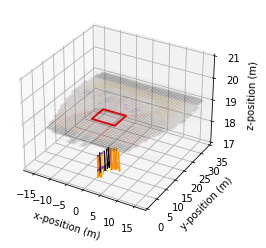

In [26]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = manual_selection_probe_position[::skip,0].copy(), manual_selection_probe_position[::skip,1].copy(), manual_selection_probe_position[::skip,2].copy()

# make the direction data for the arrows
u, v, w = manual_selection_probe_orientation_axial[::skip,0].copy(), manual_selection_probe_orientation_axial[::skip,1].copy(), manual_selection_probe_orientation_axial[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# plt.plot(manual_selection_housing_position[:,0], manual_selection_housing_position[:,1], manual_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = manual_selection_sensed_forces_local_frame[::skip,2]/manual_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = manual_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

# position_scale = 100
# # force_scale = 0.1
# force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='r', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=1, normalize=True)
# plt.colorbar(sm)

# plot phantom
# black phantom top (560-145)=415 px wide (31cm)
# empty left space next to top 145px wide
# phantom black top to black bottom (498-38)=460 px tall
phantom_width_top = 415
CM_PER_PX = 31/phantom_width_top
empty_width_left = 145
empty_width_right = empty_width_left
phantom_height = 460
empty_height_top = 38
empty_height_bottom = 532-498

# img = plt.imread("images/phantom_anatomy.png")
img = plt.imread("images/phantom_anatomy.png").transpose(1,0,2) # transpose x- and y-coordinates
img = img[:, ::-1, :] # flip y-coordinates
img[:,:,-1][(img[:,:,-1]>0.1)] = 0.1

x_phantom, y_phantom = np.mgrid[0:img.shape[0], 0:img.shape[1]].astype(float)
# translate x- and y-coordinates
x_phantom -= empty_width_left + phantom_width_top/2
y_phantom -= empty_height_bottom
# scale x- and y-coordinates
x_phantom *= CM_PER_PX
y_phantom *= CM_PER_PX

phantom_height = 19

ax.plot_surface(x_phantom, y_phantom, np.atleast_2d(phantom_height), rstride=10, cstride=10, facecolors=img)

# plot bounding box around probe path
rect_offset = 1
x_rect = [x.min()-rect_offset,x.max()+rect_offset,x.max()+rect_offset,x.min()-rect_offset]
y_rect = [y.min()-rect_offset,y.min()-rect_offset,y.max()+rect_offset,y.max()+rect_offset]
z_rect = [phantom_height,phantom_height,phantom_height,phantom_height]
verts = [list(zip(x_rect,y_rect,z_rect))]
num_verts = len(verts)
ax.add_collection3d(Poly3DCollection(verts,
                                     linewidths=[2]*num_verts, edgecolors=['r']*num_verts, facecolors=['none']*num_verts))

# ax.set_xlim([-4, 1])
# ax.set_ylim([12, 16])
ax.set_xlim([-17.5, 17.5])
ax.set_ylim([0, 35])
ax.set_zlim([phantom_height-2,phantom_height+2])

# ax.view_init(elev=90, azim=-90) # view from the top

ax.set_xlabel('x-position (m)')
ax.set_ylabel('y-position (m)')
ax.set_zlabel('z-position (m)')
plt.show()

In [27]:
# plt.plot(manual_selection_time, manual_selection_sensed_forces_local_frame[:,0], 'r')
# plt.plot(manual_selection_time, manual_selection_sensed_forces_local_frame[:,1], 'g')
plt.plot((manual_selection_time-manual_selection_time.min())/(manual_selection_time.max()-manual_selection_time.min()),
         manual_selection_sensed_forces_local_frame[:,2], 'k')
# plt.yticks(np.linspace(-2, 2, 5))
plt.title('Probe applied normal force during scan')
plt.legend(['x', 'y', 'z'], loc='lower right')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

In [28]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(manual_selection_probe_position[::skip,0],
        manual_selection_probe_position[::skip,1],
        manual_selection_sensed_forces_local_frame[::skip,2])
ax.set_title('Probe applied normal force during scan')
plt.close()
plt.show()

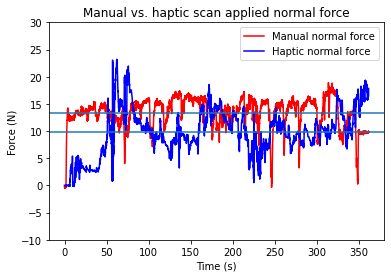

In [29]:
start_idx = 0
# end_idx = int(9.2e3)
end_idx = np.size(manual_time)
plt.plot(manual_time[start_idx:end_idx], manual_sensed_forces_local_frame[start_idx:end_idx,2], 'r')
plt.plot(haptic_robot_time[start_idx:end_idx], haptic_robot_sensed_forces_local_frame[start_idx:end_idx,2], 'b')

plt.axhline(np.average(manual_sensed_forces_local_frame[start_idx:end_idx,2]))
plt.axhline(np.average(haptic_robot_sensed_forces_local_frame[start_idx:end_idx,2]))

plt.yticks(np.linspace(-10, 30, 9))
plt.title('Manual vs. haptic scan applied normal force')
plt.legend(['Manual normal force', 'Haptic normal force'], loc='upper right')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.show()

In [30]:
plt.plot(haptic_robot_time[start_idx:end_idx], haptic_robot_sensed_forces_local_frame[start_idx:end_idx,0], 'r')
plt.plot(haptic_robot_time[start_idx:end_idx], haptic_robot_sensed_forces_local_frame[start_idx:end_idx,1], 'g')
plt.plot(haptic_robot_time[start_idx:end_idx], haptic_robot_sensed_forces_local_frame[start_idx:end_idx,2], 'b')
plt.yticks(np.linspace(-10, 30, 9))
plt.title('Probe sensed force in FT sensor frame')
plt.legend(['x', 'y', 'z'], loc='upper right')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

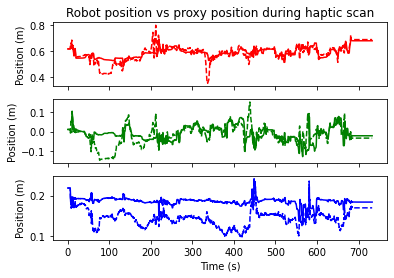

In [31]:
fig, axs = plt.subplots(3, 1, sharex='col')
axs[0].plot(haptic_robot_time, haptic_robot_ee_position[:,0], 'r')
axs[1].plot(haptic_robot_time, haptic_robot_ee_position[:,1], 'g')
axs[2].plot(haptic_robot_time, haptic_robot_ee_position[:,2], 'b')
axs[0].plot(haptic_robot_time, haptic_robot_proxy_position[:,0], '--r')
axs[1].plot(haptic_robot_time, haptic_robot_proxy_position[:,1], '--g')
axs[2].plot(haptic_robot_time, haptic_robot_proxy_position[:,2], '--b')
# plt.yticks(np.linspace(-0.5, 0.5, 5))
axs[0].set_title('Robot position vs proxy position during haptic scan')
# plt.legend(['x', 'y', 'z'], loc='center right')
axs[0].set_ylabel('Position (m)')
axs[1].set_ylabel('Position (m)')
axs[2].set_ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

In [32]:
fig, axs = plt.subplots(3, 1, sharex='col')
axs[0].plot(haptic_robot_time, haptic_probe_position_phantom_frame[:,0], 'r')
axs[1].plot(haptic_robot_time, haptic_probe_position_phantom_frame[:,1], 'g')
axs[2].plot(haptic_robot_time, haptic_probe_position_phantom_frame[:,2], 'b')
axs[0].plot(manual_time, manual_probe_position_phantom_frame[:,0], '--k')
axs[1].plot(manual_time, manual_probe_position_phantom_frame[:,1], '--k')
axs[2].plot(manual_time, manual_probe_position_phantom_frame[:,2], '--k')
# plt.yticks(np.linspace(-0.5, 0.5, 5))
axs[0].set_title('Haptic vs manual probe position')
# plt.legend(['x', 'y', 'z'], loc='center right')
axs[0].set_ylabel('Position (m)')
axs[1].set_ylabel('Position (m)')
axs[2].set_ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.close()
plt.show()

**Plot over organs in haptic scan data**\
*Transverse plane*\
0:26 - 1:44/3:03 liver\
3:04 - 3:54 gallbladder\
4:11 - 4:28 right kidney\
4:44 - 5:26 pancreas\
6:32 - 6:58 left kidney

*Sagittal plane*\
8:44 - 9:10 gallbladder\
9:43 - 9:57 right kidney\
10:32 - 10:42 left kidney

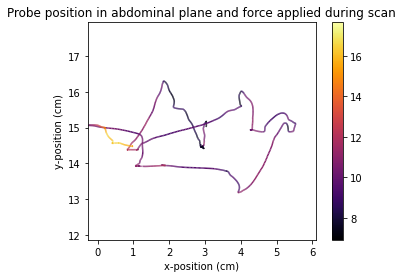

In [33]:
x, y = haptic_selection_probe_position[:,0].copy(), haptic_selection_probe_position[:,1].copy()
z = haptic_selection_sensed_forces_local_frame[:,2].copy()

cmap = plt.get_cmap('inferno')

fig, ax = plt.subplots()
fig.gca().set_aspect('equal')

seg_plot(ax, x*100, y*100, z, cmap=cmap)
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')

plt.title('Probe position in abdominal plane and force applied during scan')
plt.ylabel('y-position (cm)')
plt.xlabel('x-position (cm)')
plt.show()

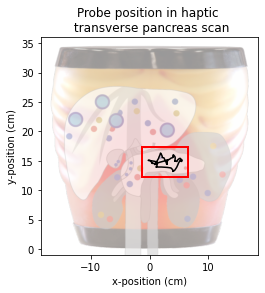

In [34]:
x, y = haptic_selection_probe_position[:,0].copy(), haptic_selection_probe_position[:,1].copy()
z = haptic_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

fig, ax = plt.subplots()
fig.gca().set_aspect('equal')

# seg_plot(ax, x, y, z, cmap=cmap)
ax.plot(x, y, 'k')
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# cbar = fig.colorbar(sm, ax=None, orientation='vertical')

# plot bounding box around probe path
rect_offset = 1
rect = patches.Rectangle((x.min()-rect_offset, y.min()-rect_offset),
                         x.ptp()+2*rect_offset, y.ptp()+2*rect_offset,
                         linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.title(f'Probe position in haptic \n {plane} {organ} scan')
plt.ylabel('y-position (cm)')
plt.xlabel('x-position (cm)')

# plot phantom
# black phantom top (560-145)=415 px wide (31cm)
# empty left space next to top 145px wide
# phantom black top to black bottom (498-38)=460 px tall
phantom_width_top = 415
CM_PER_PX = 31/phantom_width_top
empty_width_left = 145
empty_width_right = empty_width_left
phantom_height = 460
empty_height_top = 38
empty_height_bottom = 532-498

img = plt.imread("images/phantom_anatomy.png")
plt.imshow(img, alpha=0.4, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])

plt.xlim([-17.5-1, 17.5+1])
plt.ylim([0-1, 35+1])

# plt.savefig(f"plots/probe_path_phantom_{plane}_{organ}_haptic.png", dpi=dpi, bbox_inches='tight')
plt.show()

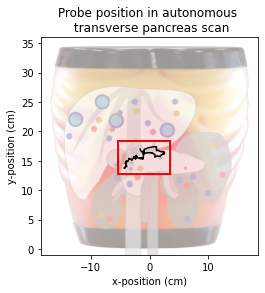

In [35]:
x, y = auto_selection_probe_position[:,0].copy(), auto_selection_probe_position[:,1].copy()
z = auto_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

dpi = 600
# fig, ax = plt.subplots(figsize=(3600/dpi,2400/dpi))
fig, ax = plt.subplots()
fig.gca().set_aspect('equal')

# seg_plot(ax, x, y, z, cmap=cmap)
ax.plot(x, y, 'k')
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# cbar = fig.colorbar(sm, ax=None, orientation='vertical')

# plot bounding box around probe path
rect_offset = 1
rect = patches.Rectangle((x.min()-rect_offset, y.min()-rect_offset),
                         x.ptp()+2*rect_offset, y.ptp()+2*rect_offset,
                         linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.title(f'Probe position in autonomous \n {plane} {organ} scan')
plt.ylabel('y-position (cm)')
plt.xlabel('x-position (cm)')

# plot phantom
# black phantom top (560-145)=415 px wide (31cm)
# empty left space next to top 145px wide
# phantom black top to black bottom (498-38)=460 px tall
phantom_width_top = 415
CM_PER_PX = 31/phantom_width_top
empty_width_left = 145
empty_width_right = empty_width_left
phantom_height = 460
empty_height_top = 38
empty_height_bottom = 532-498

img = plt.imread("images/phantom_anatomy.png")
plt.imshow(img, alpha=0.4, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])

plt.xlim([-17.5-1, 17.5+1])
plt.ylim([0-1, 35+1])

# plt.savefig(f"plots/probe_path_phantom_{plane}_{organ}_auto.png", dpi=dpi, bbox_inches='tight')
plt.show()

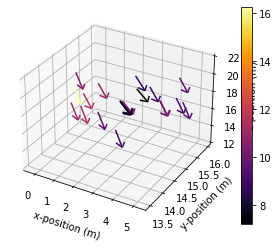

In [36]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = haptic_selection_probe_position[::skip,0].copy(), haptic_selection_probe_position[::skip,1].copy(), haptic_selection_probe_position[::skip,2].copy()

# Make the direction data for the arrows
u, v, w = haptic_selection_probe_orientation_axial[::skip,0].copy(), haptic_selection_probe_orientation_axial[::skip,1].copy(), haptic_selection_probe_orientation_axial[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# offset z for comparison to manual data
z -= 1

# plt.plot(haptic_selection_housing_position[:,0], haptic_selection_housing_position[:,1], haptic_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = haptic_selection_sensed_forces_local_frame[::skip,2]/haptic_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = haptic_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

position_scale = 100
# force_scale = 0.1
force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='k', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
colors = norm(axial_force)
colors = np.concatenate((colors, np.repeat(colors, 2)))

# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u, v, w,
#           color=cmap(norm(axial_force)), arrow_length_ratio=0.3, length=2, normalize=True)
plt.colorbar(sm)

# position_scale = 100
# force_scale = 0.1
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           -u*alphas*force_scale, -v*alphas*force_scale, -w*alphas*force_scale,
#           alpha=1, color='k', arrow_length_ratio=0.3)

# position_scale = 100
# force_scale = 0.05
# ax.quiver(z*position_scale, x*position_scale, np.ones_like(y),
#           -w*axial_force*force_scale, -u*axial_force*force_scale, -v*axial_force*force_scale,
#           alpha=alphas)

phantom_height = 17
ax.set_zlim([phantom_height-5,phantom_height+5])

ax.set_xlabel('x-position (m)')
ax.set_ylabel('y-position (m)')
ax.set_zlabel('z-position (m)')
plt.show()

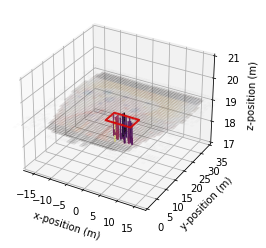

In [37]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = haptic_selection_probe_position[::skip,0].copy(), haptic_selection_probe_position[::skip,1].copy(), haptic_selection_probe_position[::skip,2].copy()

# make the direction data for the arrows
u, v, w = haptic_selection_probe_orientation_axial[::skip,0].copy(), haptic_selection_probe_orientation_axial[::skip,1].copy(), haptic_selection_probe_orientation_axial[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# offset z for comparison to manual data
z -= 1

# plt.plot(haptic_selection_housing_position[:,0], haptic_selection_housing_position[:,1], haptic_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = haptic_selection_sensed_forces_local_frame[::skip,2]/haptic_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = haptic_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

# position_scale = 100
# # force_scale = 0.1
# force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='r', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=1, normalize=True)
# plt.colorbar(sm)

# plot phantom
# black phantom top (560-145)=415 px wide (31cm)
# empty left space next to top 145px wide
# phantom black top to black bottom (498-38)=460 px tall
phantom_width_top = 415
CM_PER_PX = 31/phantom_width_top
empty_width_left = 145
empty_width_right = empty_width_left
phantom_height = 460
empty_height_top = 38
empty_height_bottom = 532-498

# img = plt.imread("images/phantom_anatomy.png")
img = plt.imread("images/phantom_anatomy.png").transpose(1,0,2) # transpose x- and y-coordinates
img = img[:, ::-1, :] # flip y-coordinates
img[:,:,-1][(img[:,:,-1]>0.1)] = 0.1

x_phantom, y_phantom = np.mgrid[0:img.shape[0], 0:img.shape[1]].astype(float)
# translate x- and y-coordinates
x_phantom -= empty_width_left + phantom_width_top/2
y_phantom -= empty_height_bottom
# scale x- and y-coordinates
x_phantom *= CM_PER_PX
y_phantom *= CM_PER_PX

phantom_height = 19

ax.plot_surface(x_phantom, y_phantom, np.atleast_2d(phantom_height), rstride=10, cstride=10, facecolors=img)

# plot bounding box around probe path
rect_offset = 1
x_rect = [x.min()-rect_offset,x.max()+rect_offset,x.max()+rect_offset,x.min()-rect_offset]
y_rect = [y.min()-rect_offset,y.min()-rect_offset,y.max()+rect_offset,y.max()+rect_offset]
z_rect = [phantom_height,phantom_height,phantom_height,phantom_height]
verts = [list(zip(x_rect,y_rect,z_rect))]
num_verts = len(verts)
ax.add_collection3d(Poly3DCollection(verts,
                                     linewidths=[2]*num_verts, edgecolors=['r']*num_verts, facecolors=['none']*num_verts))

# ax.set_xlim([-4, 1])
# ax.set_ylim([12, 16])
ax.set_xlim([-17.5, 17.5])
ax.set_ylim([0, 35])
ax.set_zlim([phantom_height-2,phantom_height+2])

# ax.view_init(elev=90, azim=-90) # view from the top

ax.set_xlabel('x-position (m)')
ax.set_ylabel('y-position (m)')
ax.set_zlabel('z-position (m)')
plt.show()

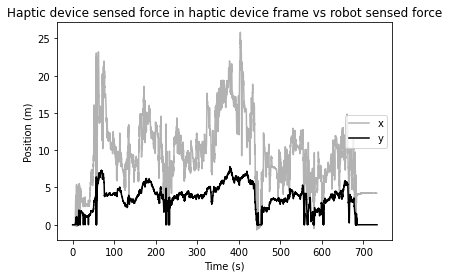

In [38]:
plt.plot(haptic_device_time[:haptic_robot_num_data_points], haptic_robot_sensed_forces_local_frame[:,2],
         'k', alpha=0.3)

# plt.plot(haptic_device_time, haptic_device_desired_force[:,0], 'r')
# plt.plot(haptic_device_time, haptic_device_desired_force[:,1], 'g')
plt.plot(haptic_device_time, np.linalg.norm(haptic_device_desired_force, axis=1), 'k')

# plt.yticks(np.linspace(-0.5, 0.5, 5))
plt.title('Haptic device sensed force in haptic device frame vs robot sensed force')
plt.legend(['x', 'y', 'z'], loc='center right')
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

Plot robot force and haptic device magnitudes over trajectory traced

In [39]:
# fig, ax = plt.subplots(2, 1, sharey=True, subplot_kw=dict(aspect='equal'))
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(5,5))

x, y = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy()
z = manual_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

seg_plot(ax[0], x, y, z, cmap=cmap)

# highlight image comparison points
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
ax[0].plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

# keep track of min and max values
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
z_min, z_max = z.min(), z.max()

x, y = haptic_selection_probe_position[:,0].copy(), haptic_selection_probe_position[:,1].copy()
z = haptic_selection_sensed_forces_local_frame[:,2].copy()

x, y = auto_selection_probe_position[:,0].copy(), auto_selection_probe_position[:,1].copy()
z = auto_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

seg_plot(ax[1], x, y, z, cmap=cmap)

# highlight image comparison points
# x_comp = [x[haptic_ori_ind]]
# y_comp = [y[haptic_ori_ind]]
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
ax[1].plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

# keep track of min and max values
x_min, x_max = min(x_min, x.min()), max(x_max, x.max())
y_min, y_max = min(y_min, y.min()), max(y_max, y.max())
z_min, z_max = min(z_min, z.min()), max(z_max, z.max())

## add a big axis, hide frame
fig.add_subplot(111, frameon=False)
## hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title("Probe position in abdominal plane and force applied during scan")
plt.xlabel("x-position (cm)")
plt.ylabel("y-position (cm)")

# add colorbar
norm = plt.Normalize(z_min, z_max)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.65])
cbar = plt.colorbar(sm, ax=None, orientation='vertical', cax=cbar_ax, label="axial force (N)")
# cbar = plt.colorbar(sm, ax=None, orientation='vertical', label="axial force (N)")

# setting the values for all axes
x_offset = 0.5
y_offset = 0.5
xlim = [x_min-x_offset,x_max+x_offset]
ylim = [y_min-y_offset,y_max+y_offset]
plt.setp(ax, xlim=xlim, ylim=ylim)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
# ax[1].legend(loc='upper left', fontsize='small', frameon=False)
ax[0].legend(loc='upper center', bbox_to_anchor=(1.264, 1),
          frameon=False, ncol=5)
plt.close()
plt.show()

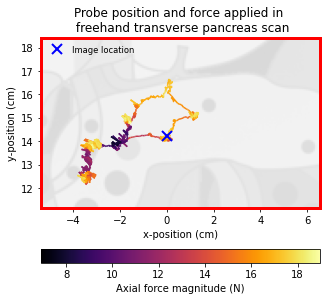

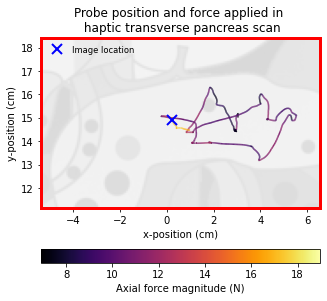

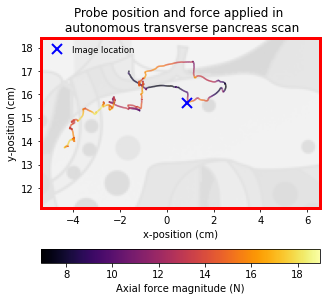

In [50]:
# fig, ax = plt.subplots(2, 1, sharey=True, subplot_kw=dict(aspect='equal'))
# fig, ax = plt.subplots(2, 1, sharey=True, figsize=(5,5))

fig1, ax1 = plt.subplots(figsize=(5,5))
fig2, ax2 = plt.subplots(figsize=(5,5))
fig3, ax3 = plt.subplots(figsize=(5,5))
fig1.gca().set_aspect('equal')
fig2.gca().set_aspect('equal')
fig3.gca().set_aspect('equal')

x, y = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy()
z = manual_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

cmap = plt.get_cmap('inferno')

seg_plot(ax1, x, y, z, cmap=cmap)

# highlight image comparison points
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
ax1.plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="Image location")

# keep track of min and max values
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
z_min, z_max = z.min(), z.max()

x, y = haptic_selection_probe_position[:,0].copy(), haptic_selection_probe_position[:,1].copy()
z = haptic_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

seg_plot(ax2, x, y, z, cmap=cmap)

# highlight image comparison points
x_comp = [x[haptic_ori_ind]]
y_comp = [y[haptic_ori_ind]]
ax2.plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="Image location")

# keep track of min and max values
x_min, x_max = min(x_min, x.min()), max(x_max, x.max())
y_min, y_max = min(y_min, y.min()), max(y_max, y.max())
z_min, z_max = min(z_min, z.min()), max(z_max, z.max())

x, y = auto_selection_probe_position[:,0].copy(), auto_selection_probe_position[:,1].copy()
z = auto_selection_sensed_forces_local_frame[:,2].copy()

# scale position data
x *= 100
y *= 100

seg_plot(ax3, x, y, z, cmap=cmap)

# highlight image comparison points
# x_comp = [x[auto_pos_ind]]
# y_comp = [y[auto_pos_ind]]
x_comp = [x[auto_pos_ind]]
y_comp = [y[auto_pos_ind]]
ax3.plot(x_comp, y_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="Image location")

# keep track of min and max values
x_min, x_max = min(x_min, x.min()), max(x_max, x.max())
y_min, y_max = min(y_min, y.min()), max(y_max, y.max())
z_min, z_max = min(z_min, z.min()), max(z_max, z.max())

# add colorbars
norm = plt.Normalize(z_min, z_max)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# fig1.subplots_adjust(right=0.8)
# cbar_ax1 = fig1.add_axes([0.15, 0.2, 0.6, 0.025])
# cbar1 = plt.colorbar(sm, ax=None, orientation='horizontal', cax=cbar_ax1, label="Axial force (N)")

# fig2.subplots_adjust(right=0.8)
# cbar_ax2 = fig2.add_axes([0.85, 0.25, 0.025, 0.45])
# cbar2 = plt.colorbar(sm, ax=None, orientation='vertical', cax=cbar_ax2, label="Axial force (N)")

cbar1 = fig1.colorbar(sm, orientation='horizontal', label="Axial force magnitude (N)")
cbar2 = fig2.colorbar(sm, orientation='horizontal', label="Axial force magnitude (N)")
cbar3 = fig3.colorbar(sm, orientation='horizontal', label="Axial force magnitude (N)")

directions = ['bottom', 'top', 'right', 'left']
for i, direction in enumerate(directions):
    ax1.spines[direction].set_color('red')
    ax1.spines[direction].set_linewidth('3')
    ax2.spines[direction].set_color('red')
    ax2.spines[direction].set_linewidth('3')
    ax3.spines[direction].set_color('red')
    ax3.spines[direction].set_linewidth('3')

offset = 1
ax1.set_xlim([x_min-offset, x_max+offset])
ax1.set_ylim([y_min-offset, y_max+offset])
ax2.set_xlim([x_min-offset, x_max+offset])
ax2.set_ylim([y_min-offset, y_max+offset])
ax3.set_xlim([x_min-offset, x_max+offset])
ax3.set_ylim([y_min-offset, y_max+offset])

ax1.legend(loc='upper left', fontsize='small', frameon=False)
ax1.set_title(f"Probe position and force applied in \n freehand {plane} {organ} scan")
ax1.set_xlabel("x-position (cm)")
ax1.set_ylabel("y-position (cm)")

ax2.legend(loc='upper left', fontsize='small', frameon=False)
ax2.set_title(f"Probe position and force applied in \n haptic {plane} {organ} scan")
ax2.set_xlabel("x-position (cm)")
ax2.set_ylabel("y-position (cm)")

ax3.legend(loc='upper left', fontsize='small', frameon=False)
ax3.set_title(f"Probe position and force applied in \n autonomous {plane} {organ} scan")
ax3.set_xlabel("x-position (cm)")
ax3.set_ylabel("y-position (cm)")

if True:
    # plot phantom
    # black phantom top (560-145)=415 px wide (31cm)
    # empty left space next to top 145px wide
    # phantom black top to black bottom (498-38)=460 px tall
    phantom_width_top = 415
    CM_PER_PX = 31/phantom_width_top
    empty_width_left = 145
    empty_width_right = empty_width_left
    phantom_height = 460
    empty_height_top = 38
    empty_height_bottom = 532-498
    img = plt.imread("images/phantom_anatomy.png")
    img = np.dot(img[...,:3], [0.299, 0.587, 0.144])
    ax1.imshow(img, cmap='gray', alpha=0.2, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])
    ax2.imshow(img, cmap='gray', alpha=0.2, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])
    ax3.imshow(img, cmap='gray', alpha=0.2, extent=[-(phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    (phantom_width_top/2+empty_width_left)*CM_PER_PX,
                                    -empty_height_bottom*CM_PER_PX,
                                    (phantom_height+empty_height_top)*CM_PER_PX])

dpi=600
fig1.savefig(f"plots/probe_path_force_{plane}_{organ}_manual.png", dpi=dpi, bbox_inches='tight')
# fig2.savefig(f"plots/probe_path_force_{plane}_{organ}_haptic.png", dpi=dpi, bbox_inches='tight')
# fig3.savefig(f"plots/probe_path_force_{plane}_{organ}_auto.png", dpi=dpi, bbox_inches='tight')

plt.show()

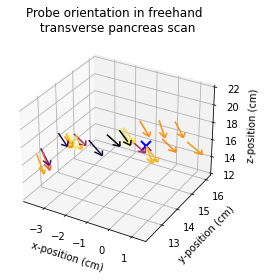

In [55]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = manual_selection_probe_position[::skip,0].copy(), manual_selection_probe_position[::skip,1].copy(), manual_selection_probe_position[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# make the direction data for the arrows
u, v, w = manual_selection_probe_orientation_axial[::skip,0].copy(), manual_selection_probe_orientation_axial[::skip,1].copy(), manual_selection_probe_orientation_axial[::skip,2].copy()

# plt.plot(manual_selection_housing_position[:,0], manual_selection_housing_position[:,1], manual_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = manual_selection_sensed_forces_local_frame[::skip,2]/manual_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = manual_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

position_scale = 100
# force_scale = 0.1
force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='k', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
colors = norm(axial_force)
colors = np.concatenate((colors, np.repeat(colors, 2)))

# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u, v, w,
#           color=cmap(norm(axial_force)), arrow_length_ratio=0.3, length=2, normalize=True)

# plt.colorbar(sm, orientation='horizontal', label="Axial force (N)")

# highlight image comparison point
x, y, z = manual_selection_probe_position[:,0].copy(), manual_selection_probe_position[:,1].copy(), manual_selection_probe_position[:,2].copy()
x *= 100
y *= 100
z *= 100
u, v, w = manual_selection_probe_orientation_axial[:,0].copy(), manual_selection_probe_orientation_axial[:,1].copy(), manual_selection_probe_orientation_axial[:,2].copy()
x_comp = [x[manual_ori_ind]]
y_comp = [y[manual_ori_ind]]
z_comp = [z[manual_ori_ind]]
u_comp = [u[manual_ori_ind]]
v_comp = [v[manual_ori_ind]]
w_comp = [w[manual_ori_ind]]
comp_force = [manual_selection_sensed_forces_local_frame[manual_ori_ind,2].copy()]
c = axial_force
c = (comp_force - c.min()) / c.ptp()
c = np.concatenate((c, np.repeat(c, 2)))
c = cmap(c)
ax.quiver(x_comp, y_comp, z_comp,
          u_comp, v_comp, w_comp,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
ax.plot(x_comp, y_comp, z_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

phantom_height = 17
ax.set_zlim([phantom_height-5,phantom_height+5])

ax.set_title(f"Probe orientation in freehand \n {plane} {organ} scan")
ax.set_xlabel('x-position (cm)')
ax.set_ylabel('y-position (cm)')
ax.set_zlabel('z-position (cm)')

dpi = 600
plt.savefig(f"plots/probe_ori_{plane}_{organ}_manual.png", dpi=dpi, bbox_inches='tight')

plt.show()

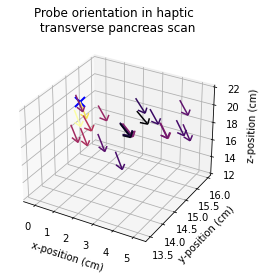

In [54]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = haptic_selection_probe_position[::skip,0].copy(), haptic_selection_probe_position[::skip,1].copy(), haptic_selection_probe_position[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# make the direction data for the arrows
u, v, w = haptic_selection_probe_orientation_axial[::skip,0].copy(), haptic_selection_probe_orientation_axial[::skip,1].copy(), haptic_selection_probe_orientation_axial[::skip,2].copy()

# plt.plot(haptic_selection_housing_position[:,0], haptic_selection_housing_position[:,1], haptic_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = haptic_selection_sensed_forces_local_frame[::skip,2]/haptic_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = haptic_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

position_scale = 100
# force_scale = 0.1
force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='k', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
colors = norm(axial_force)
colors = np.concatenate((colors, np.repeat(colors, 2)))

# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u, v, w,
#           color=cmap(norm(axial_force)), arrow_length_ratio=0.3, length=2, normalize=True)

# plt.colorbar(sm, orientation='horizontal', label="Axial force (N)")

# highlight image comparison point
x, y, z = haptic_selection_probe_position[:,0].copy(), haptic_selection_probe_position[:,1].copy(), haptic_selection_probe_position[:,2].copy()
x *= 100
y *= 100
z *= 100
u, v, w = haptic_selection_probe_orientation_axial[:,0].copy(), haptic_selection_probe_orientation_axial[:,1].copy(), haptic_selection_probe_orientation_axial[:,2].copy()
x_comp = [x[haptic_ori_ind]]
y_comp = [y[haptic_ori_ind]]
z_comp = [z[haptic_ori_ind]]
u_comp = [u[haptic_ori_ind]]
v_comp = [v[haptic_ori_ind]]
w_comp = [w[haptic_ori_ind]]
comp_force = [haptic_selection_sensed_forces_local_frame[haptic_ori_ind,2].copy()]
c = axial_force
c = (comp_force - c.min()) / c.ptp()
c = np.concatenate((c, np.repeat(c, 2)))
c = cmap(c)
ax.quiver(x_comp, y_comp, z_comp,
          u_comp, v_comp, w_comp,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
ax.plot(x_comp, y_comp, z_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

phantom_height = 17
ax.set_zlim([phantom_height-5,phantom_height+5])

ax.set_title(f"Probe orientation in haptic \n {plane} {organ} scan")
ax.set_xlabel('x-position (cm)')
ax.set_ylabel('y-position (cm)')
ax.set_zlabel('z-position (cm)')

dpi = 600
plt.savefig(f"plots/probe_ori_{plane}_{organ}_haptic.png", dpi=dpi, bbox_inches='tight')

plt.show()

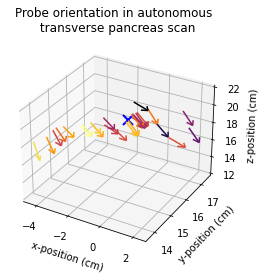

In [53]:
skip = 200
ax = plt.figure().add_subplot(projection='3d')

# make the grid
x, y, z = auto_selection_probe_position[::skip,0].copy(), auto_selection_probe_position[::skip,1].copy(), auto_selection_probe_position[::skip,2].copy()

# scale position data
x *= 100
y *= 100
z *= 100

# make the direction data for the arrows
u, v, w = auto_selection_probe_orientation_axial[::skip,0].copy(), auto_selection_probe_orientation_axial[::skip,1].copy(), auto_selection_probe_orientation_axial[::skip,2].copy()

# plt.plot(auto_selection_housing_position[:,0], auto_selection_housing_position[:,1], auto_selection_housing_position[:,2])
# plt.yticks(np.linspace(-0.5, 0.5, 5))

# axial_force_normalized = auto_selection_sensed_forces_local_frame[::skip,2]/auto_selection_sensed_forces_local_frame[::skip,2].max()
axial_force = auto_selection_sensed_forces_local_frame[::skip,2].copy()
# alphas = axial_force * (1.0/axial_force.max())
alphas = (axial_force - axial_force.min()) / (axial_force.max() - axial_force.min())
alpha_zero_offset = 0.4
alphas = alphas*(1-alpha_zero_offset) + alpha_zero_offset

position_scale = 100
# force_scale = 0.1
force_scale = 0.005
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u*axial_force*force_scale, v*axial_force*force_scale, w*axial_force*force_scale,
#           alpha=alphas, color='k', arrow_length_ratio=0.3)

norm = plt.Normalize(axial_force.min(), axial_force.max())
cmap = plt.get_cmap('inferno')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=None, orientation='vertical')
colors = norm(axial_force)
colors = np.concatenate((colors, np.repeat(colors, 2)))

# color by axial force
c = axial_force
# flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))
# colormap
c = cmap(c)
ax.quiver(x, y, z,
          u, v, w,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
# ax.quiver(x*position_scale, y*position_scale, z*position_scale,
#           u, v, w,
#           color=cmap(norm(axial_force)), arrow_length_ratio=0.3, length=2, normalize=True)

# plt.colorbar(sm, orientation='horizontal', label="Axial force (N)")

# highlight image comparison point
x, y, z = auto_selection_probe_position[:,0].copy(), auto_selection_probe_position[:,1].copy(), auto_selection_probe_position[:,2].copy()
x *= 100
y *= 100
z *= 100
u, v, w = auto_selection_probe_orientation_axial[:,0].copy(), auto_selection_probe_orientation_axial[:,1].copy(), auto_selection_probe_orientation_axial[:,2].copy()
x_comp = [x[auto_ori_ind]]
y_comp = [y[auto_ori_ind]]
z_comp = [z[auto_ori_ind]]
u_comp = [u[auto_ori_ind]]
v_comp = [v[auto_ori_ind]]
w_comp = [w[auto_ori_ind]]
comp_force = [auto_selection_sensed_forces_local_frame[auto_ori_ind,2].copy()]
c = axial_force
c = (comp_force - c.min()) / c.ptp()
c = np.concatenate((c, np.repeat(c, 2)))
c = cmap(c)
ax.quiver(x_comp, y_comp, z_comp,
          u_comp, v_comp, w_comp,
          color=c, arrow_length_ratio=0.3, length=2, normalize=True)
ax.plot(x_comp, y_comp, z_comp, marker='x', markersize=10, markeredgecolor='b', markerfacecolor='b', markeredgewidth=2,
         linestyle='None', label="image location")

phantom_height = 17
ax.set_zlim([phantom_height-5,phantom_height+5])

ax.set_title(f"Probe orientation in autonomous \n {plane} {organ} scan")
ax.set_xlabel('x-position (cm)')
ax.set_ylabel('y-position (cm)')
ax.set_zlabel('z-position (cm)')

dpi = 600
plt.savefig(f"plots/probe_ori_{plane}_{organ}_auto.png", dpi=dpi, bbox_inches='tight')

plt.show()

In [44]:
print("Average force over manual scan:", np.average(manual_selection_sensed_forces_local_frame[:,2]), "N")
print("Average force over haptic scan:", np.average(haptic_selection_sensed_forces_local_frame[:,2]), "N")

Average force over manual scan: 13.802015951466561 N
Average force over haptic scan: 10.238760248370186 N


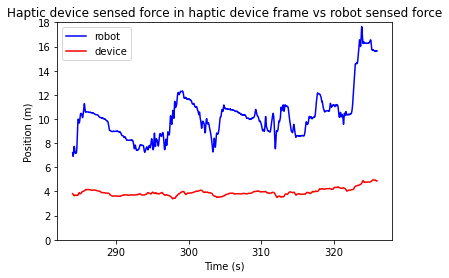

In [45]:
plt.plot(haptic_selection_time, haptic_selection_sensed_forces_local_frame[:,2], 'b', label="robot")

# plt.plot(haptic_device_time, haptic_device_desired_force[:,0], 'r')
# plt.plot(haptic_device_time, haptic_device_desired_force[:,1], 'g')
plt.plot(haptic_selection_time, haptic_selection_device_desired_force[:,2], 'r', label="device")
# plt.plot(haptic_selection_time, np.linalg.norm(haptic_selection_device_desired_force, axis=1), 'k')

plt.ylim([0,18])
plt.title('Haptic device sensed force in haptic device frame vs robot sensed force')
plt.legend(loc='upper left')
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.show()

Orientation error below does not account for orientation clutch, DO NOT USE

In [46]:
delta_phi = np.zeros((haptic_robot_num_data_points,3))
for i in range(haptic_robot_num_data_points):
    delta_phi[i] = np.cross(haptic_robot_ee_orientation[i,:,0], haptic_device_orientation[i,:,0])
    delta_phi[i] += np.cross(haptic_robot_ee_orientation[i,:,1], haptic_device_orientation[i,:,1])
    delta_phi[i] += np.cross(haptic_robot_ee_orientation[i,:,2], haptic_device_orientation[i,:,2])
    delta_phi[i] *= -0.5

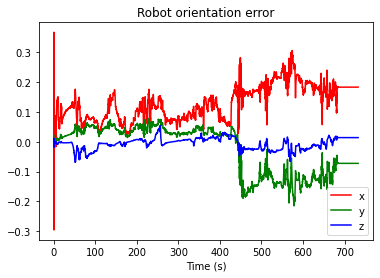

In [47]:
plt.plot(haptic_robot_time, delta_phi[:,0], 'r')
plt.plot(haptic_robot_time, delta_phi[:,1], 'g')
plt.plot(haptic_robot_time, delta_phi[:,2], 'b')
# plt.yticks(np.linspace(-2, 2, 5))
plt.title('Robot orientation error')
plt.legend(['x', 'y', 'z'], loc='lower right')
# plt.ylabel('Moment (N*m)')
plt.xlabel('Time (s)')
plt.show()